In [25]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

from src.classifier_regressor import (
    prepare_train_set, train_models, evaluate_model, plot_feature_importance
)
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Go one folder up and into data/raw/
RAW_PATH = os.path.join("..", "data", "raw")

# Load datasets
ccb = pd.read_csv(os.path.join(RAW_PATH, "credit_card_balance.csv"))
prev = pd.read_csv(os.path.join(RAW_PATH, "previous_application.csv"))

app = pd.concat([
    pd.read_csv(os.path.join(RAW_PATH, "application_train.csv")),
    pd.read_csv(os.path.join(RAW_PATH, "application_test.csv"))
], axis=0).sort_values("SK_ID_CURR").reset_index(drop=True)

bureau = pd.read_csv(os.path.join(RAW_PATH, "bureau.csv"))

In [27]:
def compute_rolling_ur_pr_separately(ccb, start_month, end_month, label):

    window = list(range(start_month, end_month + 1))
    ccb_window = ccb[ccb['MONTHS_BALANCE'].isin(window)].copy()

    # Compute ratios
    ccb_window['UR'] = ccb_window['AMT_BALANCE'] / ccb_window['AMT_CREDIT_LIMIT_ACTUAL']
    ccb_window['PR'] = ccb_window['AMT_PAYMENT_TOTAL_CURRENT'] / ccb_window['AMT_TOTAL_RECEIVABLE']

    # Sort for rolling computation
    ccb_window.sort_values(['SK_ID_CURR', 'MONTHS_BALANCE'], ascending=[True, False], inplace=True)

    # Compute 3-month rolling means
    ur_df = (
        ccb_window.groupby('SK_ID_CURR')['UR']
        .rolling(window=3, min_periods=3)
        .mean()
        .groupby(level=0)
        .last()
        .reset_index(name=f'UR_{label}')
    )

    pr_df = (
        ccb_window.groupby('SK_ID_CURR')['PR']
        .rolling(window=3, min_periods=3)
        .mean()
        .groupby(level=0)
        .last()
        .reset_index(name=f'PR_{label}')
    )

    return ur_df, pr_df

ur_789, pr_789 = compute_rolling_ur_pr_separately(ccb, -9, -7, '789')
ur_456, pr_456 = compute_rolling_ur_pr_separately(ccb, -6, -4, '456')


In [28]:
def extract_drawings(ccb_tc, months, prefix):
    """Pivot AMT_DRAWINGS_CURRENT into TC features."""
    df = ccb_tc[ccb_tc['MONTHS_BALANCE'].isin(months)]
    tc = df.pivot_table(
        index='SK_ID_CURR',
        columns='MONTHS_BALANCE',
        values='AMT_DRAWINGS_CURRENT',
        aggfunc='sum'
    ).reset_index()
    tc.columns = ['SK_ID_CURR'] + [f'{prefix}{abs(c)}' for c in months]
    return tc
# Drawings
tc_123 = extract_drawings(ccb, [-1, -2, -3], 'TC')
tc_456 = extract_drawings(ccb, [-4, -5, -6], 'TC')
tc_789 = extract_drawings(ccb, [-7, -8, -9], 'TC')

In [29]:
def generate_eo_features(ccb_eo, months, prefix):
    months = sorted(months)  # e.g., [-3, -2, -1] becomes [-3, -2, -1]
    filtered = ccb_eo[ccb_eo['MONTHS_BALANCE'].isin(months)].copy()
    filtered['cbb_non_pay'] = (filtered['SK_DPD_DEF'] > 0).astype(int)

    # Pivot: raw overdue flags
    eo = filtered.pivot_table(
        index='SK_ID_CURR',
        columns='MONTHS_BALANCE',
        values='cbb_non_pay',
        aggfunc='max'
    ).fillna(0).astype(int).reset_index()

    # Map pivoted column names to standardized EO_i_raw
    eo_col_map = {m: f"{prefix}_{i+1}_raw" for i, m in enumerate(sorted(months, reverse=True))}
    eo = eo.rename(columns=eo_col_map)

    # Compute EO_1, EO_2, EO_3 recursively
    eo[f"{prefix}_1"] = eo[f"{prefix}_1_raw"]
    eo[f"{prefix}_2"] = eo[f"{prefix}_2_raw"] * (eo[f"{prefix}_1"] + 1)
    eo[f"{prefix}_3"] = eo[f"{prefix}_3_raw"] * (eo[f"{prefix}_2"] + 1)

    # Total non-payment flags
    eo["MP_R"] = (eo[f"{prefix}_1"] > 0).astype(int) + \
                 (eo[f"{prefix}_2"] > 0).astype(int) + \
                 (eo[f"{prefix}_3"] > 0).astype(int)

    return eo[["SK_ID_CURR", f"{prefix}_1", f"{prefix}_2", f"{prefix}_3", "MP_R"]]
eo_123 = generate_eo_features(ccb, [-1, -2, -3], 'EO')
eo_456 = generate_eo_features(ccb, [-4, -5, -6], 'EO')
eo_789 = generate_eo_features(ccb, [-7, -8, -9], 'EO')

In [30]:
def extract_limit(ccb_lr, month):
    """Get L_R value from a specific month."""
    df = ccb_lr[ccb_lr['MONTHS_BALANCE'] == month][['SK_ID_CURR', 'AMT_CREDIT_LIMIT_ACTUAL']]
    return df.rename(columns={'AMT_CREDIT_LIMIT_ACTUAL': 'L_R'})
# Credit limit (L_R)
lr_1 = extract_limit(ccb, -1)
lr_4 = extract_limit(ccb, -4)
lr_7 = extract_limit(ccb, -7)

In [31]:
def compute_account_age_by_window(ccb, start_month, end_month):
    """
    Compute the number of distinct MONTHS_BALANCE entries per SK_ID_CURR
    for a given time window (e.g., -6 to -4), and rename column as N_Months_R_<label>.

    Returns a DataFrame: ['SK_ID_CURR', f'N_Months_R_{label}']
    """
    filtered = ccb[ccb['MONTHS_BALANCE'].between(start_month, end_month)]
    age_df = (
        filtered.groupby('SK_ID_CURR')['MONTHS_BALANCE']
        .nunique()
        .reset_index(name=f'N_Months_R')
    )
    return age_df
age_456 = compute_account_age_by_window(ccb, -6, -4)
age_789 = compute_account_age_by_window(ccb, -9, -7)


In [32]:
# Interest rate computation
def compute_customer_interest_rate(prev_df, fallback_rate=0.1887):
    prev_df['INT'] = prev_df['RATE_INTEREST_PRIMARY'].fillna(prev_df['RATE_INTEREST_PRIVILEGED'])
    return prev_df.groupby('SK_ID_CURR')['INT'].mean().fillna(fallback_rate).reset_index()

interest_df = compute_customer_interest_rate(prev)


In [33]:
ei = app[['SK_ID_CURR', 'AMT_INCOME_TOTAL']].rename(columns={'AMT_INCOME_TOTAL': 'EI'})

In [34]:
def simulate_limit_increase(lr_df, beta=1.5, prob=0.2, seed=None):
    """Simulate limit increase."""
    if seed is not None:
        np.random.seed(seed)
    lr_df = lr_df.copy()
    lr_df['sim_increase'] = np.random.rand(len(lr_df)) < prob
    lr_df['L_P'] = np.where(lr_df['sim_increase'], lr_df['L_R'] * beta, lr_df['L_R'])
    lr_df['HA_P'] = (lr_df['L_P'] > lr_df['L_R']).astype(int)
    return lr_df.drop(columns='sim_increase')

# Simulated limit increase
lr_1 = simulate_limit_increase(lr_1, seed=42)
lr_4 = simulate_limit_increase(lr_4, seed=43)
lr_7 = simulate_limit_increase(lr_7, seed=44)

In [35]:
def pivot_ob_balance(ccb_ob, months, prefix):
    """Pivot OB_cdayᵢ values."""
    df = ccb_ob[ccb_ob['MONTHS_BALANCE'].isin(months)]
    pivot = df.pivot_table(
        index='SK_ID_CURR',
        columns='MONTHS_BALANCE',
        values='AMT_BALANCE',
        aggfunc='first'
    ).reset_index()
    pivot.columns = ['SK_ID_CURR'] + [f'OB_cday_{abs(c)}' for c in months]
    return pivot
# OB_cdayᵢ
ccb_ob_pivot_123 = pivot_ob_balance(ccb, [-1, -2, -3], 'OB_cday')
ccb_ob_pivot_456 = pivot_ob_balance(ccb, [-4, -5, -6], 'OB_cday')
ccb_ob_pivot_789 = pivot_ob_balance(ccb, [-7, -8, -9], 'OB_cday')

In [36]:
def compute_payment_ratio(ccb_pday, months, prefix):
    """Compute and pivot P_pdayᵢ ratios."""
    df = ccb_pday[ccb_pday['MONTHS_BALANCE'].isin(months)].copy()
    df['P_pday'] = df['AMT_PAYMENT_TOTAL_CURRENT'] / df['AMT_BALANCE'].replace(0, np.nan)
    pivot = df.pivot_table(
        index='SK_ID_CURR',
        columns='MONTHS_BALANCE',
        values='P_pday',
        aggfunc='first'
    ).reset_index()
    pivot.columns = ['SK_ID_CURR'] + [f'P_pday_{abs(c)}' for c in months]
    return pivot
# Payment ratio
payment_ratio_pivot_123 = compute_payment_ratio(ccb, [-1, -2, -3], 'P_pday')
payment_ratio_pivot_456 = compute_payment_ratio(ccb, [-4, -5, -6], 'P_pday')
payment_ratio_pivot_789 = compute_payment_ratio(ccb, [-7, -8, -9], 'P_pday')

In [37]:
#take mean overdue days
bureau_score = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean().reset_index(name='BS')


In [38]:
# Average balance and classification
def classify_balance(bal):
    if bal == 0:
        return 2
    elif bal <= 75000:
        return 0
    else:
        return 1

In [39]:
def compute_avg_balance(ccb_df, months):
    df = ccb_df[ccb_df["MONTHS_BALANCE"].isin(months)]

    # Compute average balance
    avg_balance = df.groupby("SK_ID_CURR")["AMT_BALANCE"].mean().reset_index(name="AVG_BALANCE")

    # Classify balance
    avg_balance["BALANCE_CLASS"] = avg_balance["AVG_BALANCE"].apply(classify_balance)
    return avg_balance

# Example usage
avg_balance_123 = compute_avg_balance(ccb, [-1, -2, -3])
avg_balance_456 = compute_avg_balance(ccb, [-4, -5, -6])
avg_balance_789 = compute_avg_balance(ccb, [-7, -8, -9])


In [44]:
avg_balance_456["BALANCE_CLASS"].value_counts()

2    62931
1    26062
0    12462
Name: BALANCE_CLASS, dtype: int64

In [45]:
def assemble_snapshot(
    tc_df, eo_df, eo_cols, interest_rate_df, ob_df, limit_df, balance_df, pay_ratio_df,
    rename_map=None
):
    """Merge all components into a single customer snapshot DataFrame."""
    snapshot = tc_df.copy()
    snapshot = snapshot.merge(eo_df[["SK_ID_CURR"] + eo_cols], on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(interest_rate_df, on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(ob_df, on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(limit_df[["SK_ID_CURR", "L_R"]], on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(balance_df, on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(pay_ratio_df, on="SK_ID_CURR", how="inner")
    
    if rename_map:
        snapshot = snapshot.rename(columns=rename_map)
    
    return snapshot

# === Build future snapshot (M-1 to M-3) ===
future = assemble_snapshot(
    tc_df=tc_123,
    eo_df=eo_123,
    eo_cols=["EO_1", "EO_2", "EO_3"],
    interest_rate_df=interest_df,
    ob_df=ccb_ob_pivot_123,
    limit_df=lr_1,
    balance_df=avg_balance_123,
    pay_ratio_df=payment_ratio_pivot_123
)

# === Build current snapshot (M-4 to M-6) with renaming ===
current_rename = {
    "TC6": "TC3", "TC5": "TC2", "TC4": "TC1",
    "EO_4": "EO_1", "EO_5": "EO_2", "EO_6": "EO_3",
    "OB_cday_6": "OB_cday_3", "OB_cday_5": "OB_cday_2", "OB_cday_4": "OB_cday_1",
    "P_pday_6": "P_pday_3", "P_pday_5": "P_pday_2", "P_pday_4": "P_pday_1"
}
current = assemble_snapshot(
    tc_df=tc_456,
    eo_df=eo_456,
    eo_cols=["EO_1", "EO_2", "EO_3"],
    interest_rate_df=interest_df,
    ob_df=ccb_ob_pivot_456,
    limit_df=lr_4,
    balance_df=avg_balance_456,
    pay_ratio_df=payment_ratio_pivot_456,
    rename_map=current_rename
)

# === Build past snapshot (M-7 to M-9) with renaming ===
past_rename = {
    "TC9": "TC3", "TC8": "TC2", "TC7": "TC1",
    "EO_7": "EO_1", "EO_8": "EO_2", "EO_9": "EO_3",
    "OB_cday_9": "OB_cday_3", "OB_cday_8": "OB_cday_2", "OB_cday_7": "OB_cday_1",
    "P_pday_9": "P_pday_3", "P_pday_8": "P_pday_2", "P_pday_7": "P_pday_1"
}
past = assemble_snapshot(
    tc_df=tc_789,
    eo_df=eo_789,
    eo_cols=["EO_1", "EO_2", "EO_3"],
    interest_rate_df=interest_df,
    ob_df=ccb_ob_pivot_789,
    limit_df=lr_7,
    balance_df=avg_balance_789,
    pay_ratio_df=payment_ratio_pivot_789,
    rename_map=past_rename
)

# === Impute missing values using median ===
past.fillna(past.median(numeric_only=True), inplace=True)
current.fillna(future.median(numeric_only=True), inplace=True)
future.fillna(future.median(numeric_only=True), inplace=True)


### Classification


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.73      0.35      0.48      2963
           1       0.78      0.95      0.86      7354

    accuracy                           0.78     10317
   macro avg       0.76      0.65      0.67     10317
weighted avg       0.77      0.78      0.75     10317


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2963
           1       0.91      0.92      0.92      7354

    accuracy                           0.88     10317
   macro avg       0.86      0.85      0.86     10317
weighted avg       0.88      0.88      0.88     10317


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2963
           1       0.91      0.92      0.92      7354

    accuracy                           0.88     10317
   macro avg       0.86      0.85      0.86     10317
weigh

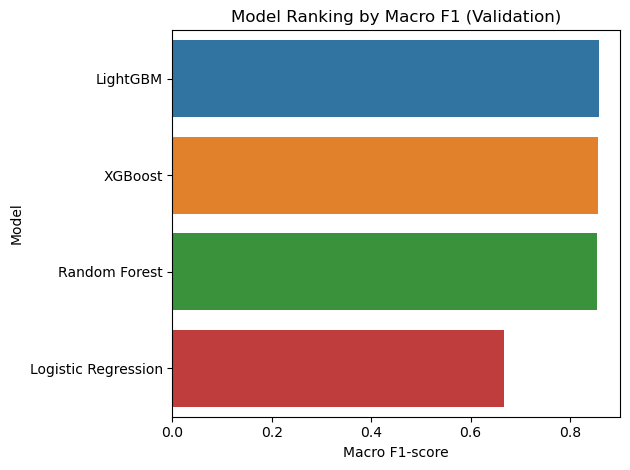


Performance on Current Data:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85     12554
           1       0.90      0.98      0.94     26163

    accuracy                           0.91     38717
   macro avg       0.92      0.87      0.89     38717
weighted avg       0.91      0.91      0.91     38717

Accuracy: 0.9101, Macro F1-score: 0.8920


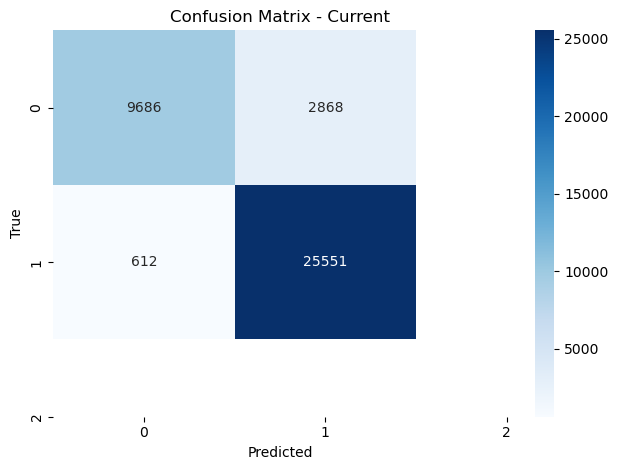


Performance on Future Data:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6431
           1       0.94      0.94      0.94     21387

    accuracy                           0.91     27818
   macro avg       0.87      0.87      0.87     27818
weighted avg       0.91      0.91      0.91     27818

Accuracy: 0.9059, Macro F1-score: 0.8678


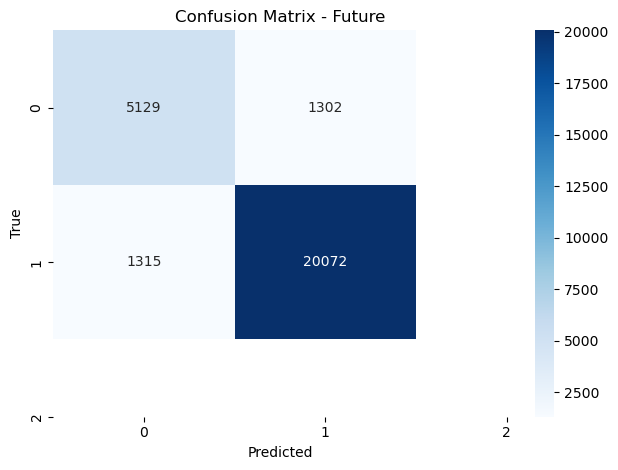


Top 10 Features - LightGBM:

      Feature  Importance
9   OB_cday_3         406
13   P_pday_3         351
2         TC3         328
7   OB_cday_1         300
12   P_pday_2         296
8   OB_cday_2         287
1         TC2         270
11   P_pday_1         262
0         TC1         249
10        L_R         228


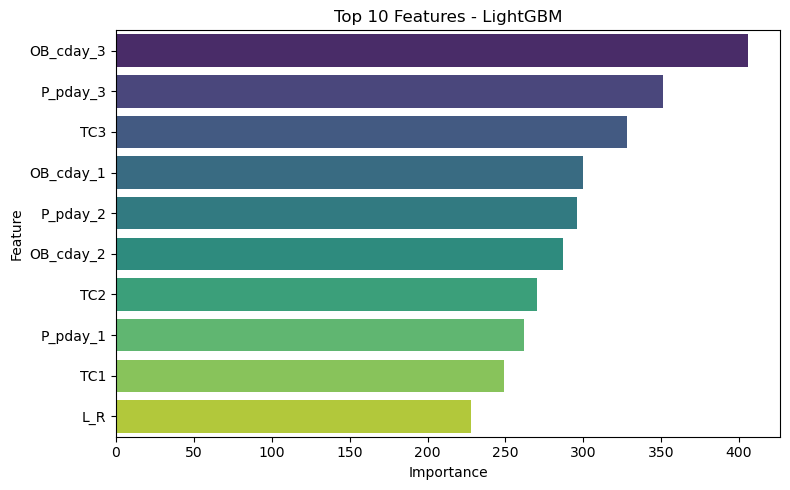

In [46]:
# === Step 1: Train/Test Split
X, y = prepare_train_set(past, current)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# === Step 2: Train and Evaluate Models
best_model, best_model_name, results_df = train_models(X_train, y_train, X_val, y_val)

# === Step 3: Predict and Evaluate on Current
X_current = current.drop(columns=["SK_ID_CURR", "BALANCE_CLASS", "AVG_BALANCE_456"], errors="ignore")
X_current = X_current[X_train.columns]
y_current = current["BALANCE_CLASS"]
y_current_pred = evaluate_model(best_model, X_current, y_current, label="Current")

col_name = f"BALANCE_CLASS_PREDICTED_{best_model_name.replace(' ', '_')}"
current[col_name] = y_current_pred

# === Step 4: Compare with Future
comparison = current.merge(future[["SK_ID_CURR", "BALANCE_CLASS"]], on="SK_ID_CURR", suffixes=("_pred", "_true"))
evaluate_model(None, comparison[col_name], comparison["BALANCE_CLASS_true"], label="Future", precomputed=True)
# === Step 5: Feature Importance
plot_feature_importance(best_model, X_train, best_model_name)

In [47]:
current.columns

Index(['SK_ID_CURR', 'TC1', 'TC2', 'TC3', 'EO_1', 'EO_2', 'EO_3', 'INT',
       'OB_cday_1', 'OB_cday_2', 'OB_cday_3', 'L_R', 'AVG_BALANCE',
       'BALANCE_CLASS', 'P_pday_1', 'P_pday_2', 'P_pday_3',
       'BALANCE_CLASS_PREDICTED_LightGBM'],
      dtype='object')

In [48]:
# === Step 6: Final Feature Correlation ===
final_df = current[['SK_ID_CURR', col_name]].copy()
final_df = final_df.rename(columns={col_name: 'BALANCE_CLASS'})

# Merge payment and utilization features
final_df = final_df.merge(pr_456, on="SK_ID_CURR", how="left") \
                   .merge(ur_456, on="SK_ID_CURR", how="left") \
                   .merge(pr_789, on="SK_ID_CURR", how="left") \
                   .merge(ur_789, on="SK_ID_CURR", how="left")

# Merge credit limit info
final_df = final_df.merge(lr_4[['SK_ID_CURR', 'L_R', 'L_P']], on="SK_ID_CURR", how="left")

# Rename and merge L_P_789 from lr_7
lr_7_renamed = lr_7[['SK_ID_CURR', 'L_P']].rename(columns={'L_P': 'L_P_789'})
final_df = final_df.merge(lr_7_renamed, on="SK_ID_CURR", how="left")

# Merge interest rate
final_df = final_df.merge(interest_df, on="SK_ID_CURR", how="left")

final_df = final_df.merge(avg_balance_123[['SK_ID_CURR', 'AVG_BALANCE']], on="SK_ID_CURR", how="left") \
                   .rename(columns={'AVG_BALANCE': 'AVG_BALANCE_123'})

# Merge and rename average balances
final_df = final_df.merge(avg_balance_456[['SK_ID_CURR', 'AVG_BALANCE']], on="SK_ID_CURR", how="left") \
                   .rename(columns={'AVG_BALANCE': 'AVG_BALANCE_456'})

final_df = final_df.merge(avg_balance_789[['SK_ID_CURR', 'AVG_BALANCE']], on="SK_ID_CURR", how="left") \
                   .rename(columns={'AVG_BALANCE': 'AVG_BALANCE_789'})

# Fill missing values
final_df = final_df.fillna(final_df.median(numeric_only=True))


In [49]:
final_df

,SK_ID_CURR,BALANCE_CLASS,PR_456,UR_456,PR_789,UR_789,L_R,L_P,L_P_789,INT,AVG_BALANCE_123,AVG_BALANCE_456,AVG_BALANCE_789
0,100049,1,0.002181,0.883164,0.054939,0.343875,135000,135000.0,90000.0,0.1887,133033.2075,89156.730,30948.750
1,100067,0,0.084909,0.986580,0.100559,0.978674,45000,45000.0,45000.0,0.1887,45606.1800,44396.085,44040.345
2,100075,1,0.406054,0.877879,0.656126,0.522516,225000,225000.0,225000.0,0.1887,181714.8825,197522.835,117566.055
3,100101,1,0.334952,0.484273,0.799689,0.401833,382500,382500.0,382500.0,0.1887,404096.1750,185234.430,152344.230
4,100107,1,0.137627,0.807661,0.180686,0.560027,135000,135000.0,135000.0,0.1887,129676.2450,109034.175,31594.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40401,456233,1,0.087435,0.202985,0.054939,0.209621,180000,180000.0,45000.0,0.1887,85344.0450,36537.360,9432.945
40402,456237,0,0.054573,0.135307,0.593809,0.364901,225000,225000.0,225000.0,0.1887,0.0000,30444.150,82102.725
40403,456242,1,0.164002,0.714039,0.054939,0.643397,225000,225000.0,225000.0,0.1887,214296.0600,160658.700,30497.175
40404,456246,0,0.054573,0.110949,0.054939,0.148387,135000,135000.0,135000.0,0.1887,31.3425,14978.085,20032.305


In [50]:
# delta_prov = (final_df['L_P'] - final_df['L_R']) / final_df['L_R']
# provision_bins = np.arange(-0.5, 1.51, 0.01)
# final_df['D_PROVISION_bin'] = pd.cut(delta_prov, bins=provision_bins, labels=False, include_lowest=True).fillna(0).astype(int)

In [51]:
# final_df.columns

In [52]:
PROCESSED_PATH = os.path.join("..", "data", "processed")
os.makedirs(PROCESSED_PATH, exist_ok=True)  # Create folder if missing

final_df.to_csv(os.path.join(PROCESSED_PATH, "cleaned_df.csv"), index=False)

In [53]:
final_df

,SK_ID_CURR,BALANCE_CLASS,PR_456,UR_456,PR_789,UR_789,L_R,L_P,L_P_789,INT,AVG_BALANCE_123,AVG_BALANCE_456,AVG_BALANCE_789
0,100049,1,0.002181,0.883164,0.054939,0.343875,135000,135000.0,90000.0,0.1887,133033.2075,89156.730,30948.750
1,100067,0,0.084909,0.986580,0.100559,0.978674,45000,45000.0,45000.0,0.1887,45606.1800,44396.085,44040.345
2,100075,1,0.406054,0.877879,0.656126,0.522516,225000,225000.0,225000.0,0.1887,181714.8825,197522.835,117566.055
3,100101,1,0.334952,0.484273,0.799689,0.401833,382500,382500.0,382500.0,0.1887,404096.1750,185234.430,152344.230
4,100107,1,0.137627,0.807661,0.180686,0.560027,135000,135000.0,135000.0,0.1887,129676.2450,109034.175,31594.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40401,456233,1,0.087435,0.202985,0.054939,0.209621,180000,180000.0,45000.0,0.1887,85344.0450,36537.360,9432.945
40402,456237,0,0.054573,0.135307,0.593809,0.364901,225000,225000.0,225000.0,0.1887,0.0000,30444.150,82102.725
40403,456242,1,0.164002,0.714039,0.054939,0.643397,225000,225000.0,225000.0,0.1887,214296.0600,160658.700,30497.175
40404,456246,0,0.054573,0.110949,0.054939,0.148387,135000,135000.0,135000.0,0.1887,31.3425,14978.085,20032.305
